<a href="https://colab.research.google.com/github/Adlaia/Pos-Grad-PUC-ML/blob/main/MVP_Machine_Learning%20-%20Amanda%20de%20Laia%20da%20Fonseca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MVP: Machine Learning & Analytics**

**Autora:** Amanda de Laia da Fonseca

**Data:** 27/09/2025

**Matrícula:** 4052025001101

**Dataset:** Drug Consumption (Quantified) - https://archive.ics.uci.edu/dataset/373/drug+consumption+quantified



# 1. Escopo, objetivo e definição do problema

O Dataset utilizado contém dados que correlacionam usuários de diferentes tipos
de drogas a diferentes tipos de personalidades (medidas pelo inventário
psicológico NEO-FFI-R), além de variáveis essenciais como idade, nacionalidade e grau de escolaridade.

Como se sabe, a política antidrogas é questão de saúde e seguraça pública, então acredito ser de grande importância uma forma de prever possíveis usuários para que o sistema público possa interferir de alguma maneira antes que a pessoa se vicie. Acesso à educação, à saúde, acompanhamento psicológico e condições mínimas de vida são algumas opções que o poder público deve oferecer à sociedade pois contribuiriam para o afastamento e a redução do uso de drogas.

Neste trabalho, por questões de tempo e objetividade, decidi pelo recorte de usuários de cocaína nos Estados Unidos. Na minha visão de leiga, antes de qualquer análise, acho que a cocaína esteja mais presente entre homens brancos, minimamente de classe média-alta (o que possivelmente implica no grau de escolaridade), com personalidade impulsiva e/ou extrovertida.

Este modelo poderia ser utilizado como base ou modelo inicial para pesquisa e predição, sendo um problema de classificação por identificar se a pessoa é ou não usuário.


Obs: o tempo total do código é em torno de 6'30", mas os itens mais demorados estão com print na caixa de texto.

# 1.1 Descritivo de variáveis e seus valores:

Os valores estão descritos nas tabelas do item 3.1, exceto para os traços de personalidade, que não entrarão em questão nesse trabalho.

*   **Classes de uso:** frequência de uso de drogas
*   **Idade:** acima de 18 anos
*   **Gênero**
*   **Educação:** grau de escolaridade
*   **País**
*   **Etinia**
*   **Neuroticismo (nscore)** - tendência à instabilidade emocional, ansiedade, mudanças e humor e emoções negativas
*   **Extrovertismo (escore)** - pessoa sociável, assertiva, energética e que busca estímulos externos
*   **Abertura à experiência (oscore)** - curiosidade intelectual, imaginação, criatividade e receptividade a novas ideias
*   **Amabilidade (ascore)** - tendência à gentileza, cooperatividade, empatia e confiança
*   **Conscienciosidade (cscore)** - tendência à organização, responsabilidade e confiança
*   **Impulsividade (impulsive)** - tendência a agir de forma rápida e espontânea sem considerar as consequências
*   **Busca por experiências intensas, novas ou arriscadas (ss)**
*   **Drogas:** Álcool, Anfetamina, Nitrito de amila, Benzodiazepínicos, Cafeína, Cannabis, Chocolate, Cocaína, Crack, Ecstasy, Heroína, Cetamina, Drogas legais, LSD, Metadona, Cogumelos alucinógenos, Nicotina, Semeron, Abuso de substâncias voláteis




# 2. Reprodutibilidade e ambiente

Importação de bibliotecas utilizadas ao longo do modelo e seed global fixa de 42 para reprodutibilidade.

In [60]:
import os, random, time, sys, math
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, precision_score,precision_recall_curve, recall_score, roc_auc_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score, silhouette_score, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV, ParameterGrid
from scipy.stats import randint, uniform, loguniform
from IPython.display import display, HTML


SEED = 42
np.random.seed(SEED)
random.seed(SEED)


print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42


# 2.2 Funções python

Definição de funções Python que serão utilizadas ao longo do modelo.
Como o problema é de classificação, foi definida essa função para avaliar as métricas de Acurácia, F1-Score, Precisão, Recall e Area Under Curve (AUC).
Aqui, entendo ser importante a identificação correta dos usuários e evitar os Falso Negativos, então o foco será no Recall. F1-Score também é importante, pelo equilíbrio entre Precisão e Recall.

Foi adicionada a variável "score" para ser considerada nos modelos que não utilizam a variável "proba".

A função para Regressão foi mantida para não quebrar algumas partes do código reaproveitadas do template cedido.

In [61]:
#Adicionado score para ser considerado nos modelos que não tem proba
def evaluate_classification(y_true, y_pred, proba=None, scores=None, pos_label=1):
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    prec = precision_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    auc = np.nan
    if proba is not None and getattr(proba, "ndim", 1) == 2 and proba.shape[1] == 2:
        auc = roc_auc_score(y_true, proba[:, 1])
    elif scores is not None:
        auc = roc_auc_score(y_true, np.ravel(scores))
    return {"accuracy": acc, "f1_weighted": f1w, "precision": prec, "recall": rec, "roc_auc": auc}


#Não utilizado
def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


## 3. Dados: carga, entendimento e qualidade

Neste modelo, foi utilizado o dataset Drug Consumption (Quantified) - https://archive.ics.uci.edu/dataset/373/drug+consumption+quantified em formato CSV hosteado na minha conta Git Hub.

O detalhamento das variáveis se encontra na seção 1 do presente trabalho.



In [62]:
# carregar o dataset direto do GitHub
url = "https://raw.githubusercontent.com/Adlaia/Pos-Grad-PUC-ML/refs/heads/main/drug_consumption.data"
df = pd.read_csv(url, header=None)

# nomear as colunas (1 id + 12 features + 19 drogas = 32)
cols = ["id","age","gender","education","country","ethnicity", "Neuroticism","Extraversion","Openness","Agreeableness","Conscientiousness","Impulsive","ImpSS", "Alcohol","Amphet","Amyl","Benzos","Caff","Cannabis","Choc","Coke","Crack", "Ecstasy","Heroin","Ketamine","Legalh","LSD","Meth","Mushrooms","Nicotine","Semer","VSA"]
df.columns = cols

# Filtrar apenas USA
df_usa = df[df["country"].round(5) == -0.57009].copy()

# Features e target (Cocaína: CL2..CL6 = usuário)
order = ["CL0","CL1","CL2","CL3","CL4","CL5","CL6"]
X = df_usa[["age","gender","education","country","ethnicity", "Neuroticism","Extraversion","Openness","Agreeableness","Conscientiousness","Impulsive","ImpSS"]]
y = df_usa["Coke"].isin(order[2:]).astype(int) #target

# Remover colunas constantes ('country' após o filtro passou a ser constante), para simplificar
const_cols = [c for c in X.columns if X[c].nunique() == 1]
X = X.drop(columns=const_cols)
feature_cols = list(X.columns)
df_usa["label"] = y.map({0: "Não-usuário (CL0–CL1)", 1: "Usuário (CL2–CL6)"}) #binaridade para problema de classificação

print("Colunas usadas em X:", list(X.columns))
print("Balanceamento de y:", y.value_counts().to_dict()) #0 para não usuário e 1 para usuário



# === Verificações iniciais ===
display(df.sample(5))
print("\nFormato:", df.shape)
print("\nTipos:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())

Colunas usadas em X: ['age', 'gender', 'education', 'ethnicity', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness', 'Impulsive', 'ImpSS']
Balanceamento de y: {1: 303, 0: 254}


,id,age,gender,education,country,ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
307,310,0.49788,-0.48246,1.16365,0.96082,-0.31685,-0.79151,0.16767,-0.17779,0.59042,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0
382,385,1.09449,0.48246,0.45468,0.96082,-0.31685,0.13606,-0.30033,-0.45174,1.11406,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0
462,465,-0.95197,0.48246,0.45468,0.96082,-0.31685,0.31287,-0.80615,1.06238,0.76096,...,CL2,CL0,CL0,CL2,CL3,CL3,CL3,CL6,CL0,CL0
1741,1745,1.82213,0.48246,-0.61113,0.96082,-0.31685,-0.46725,-0.94779,-1.42424,0.43852,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0
917,921,-0.95197,-0.48246,-1.22751,0.24923,-0.31685,0.22393,1.45421,2.15324,-0.30172,...,CL5,CL5,CL4,CL3,CL5,CL3,CL5,CL6,CL0,CL0



Formato: (1885, 32)

Tipos:
id                     int64
age                  float64
gender               float64
education            float64
country              float64
ethnicity            float64
Neuroticism          float64
Extraversion         float64
Openness             float64
Agreeableness        float64
Conscientiousness    float64
Impulsive            float64
ImpSS                float64
Alcohol               object
Amphet                object
Amyl                  object
Benzos                object
Caff                  object
Cannabis              object
Choc                  object
Coke                  object
Crack                 object
Ecstasy               object
Heroin                object
Ketamine              object
Legalh                object
LSD                   object
Meth                  object
Mushrooms             object
Nicotine              object
Semer                 object
VSA                   object
dtype: object

Valores ausentes por coluna:


### 3.1 Análise exploratória resumida (EDA)

Abaixo, adicionei tabelas filtradas por USA e Cocaína, indicando a porcentagem geral de usuários e também por gênero, etnia e formação.


Usuário x Traço


,Traço,%
0,Neuroticism,58.51
1,Extraversion,54.88
2,Openness,54.43
3,Agreeableness,51.02
4,Conscientiousness,50.17
5,Impulsive,60.06
6,ImpSS,58.79


Valor,Qtd,%,Label
0,254,45.6,Não-usuário
1,303,54.4,Usuário
Valor,Qtd,%,Label
CL0,199,35.73,Nunca
CL1,55,9.87,> Década
CL2,106,19.03,Última década
CL3,122,21.90,Último ano
CL4,50,8.98,Último mês
CL5,18,3.23,Última semana
CL6,7,1.26,Último dia


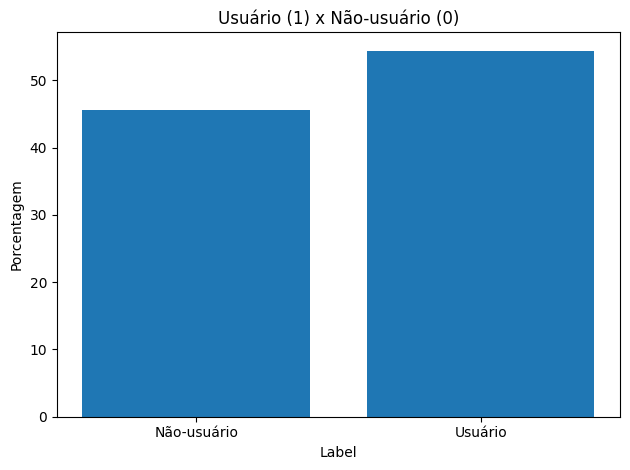

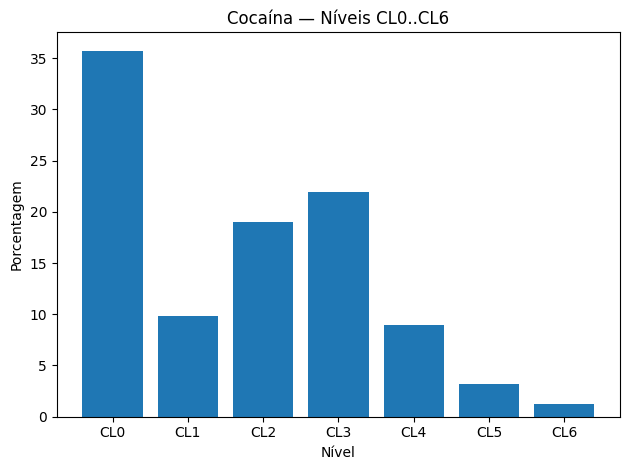

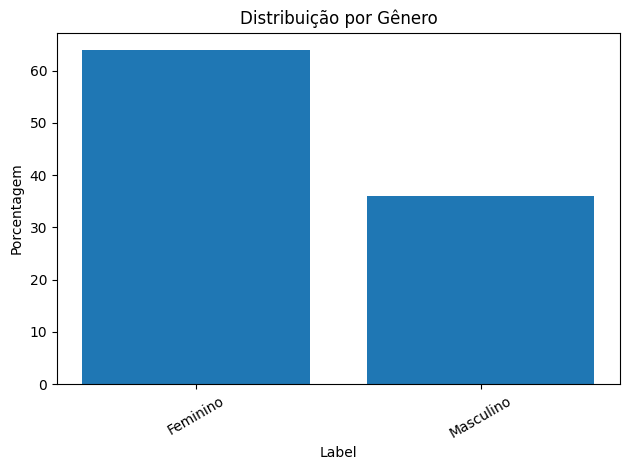

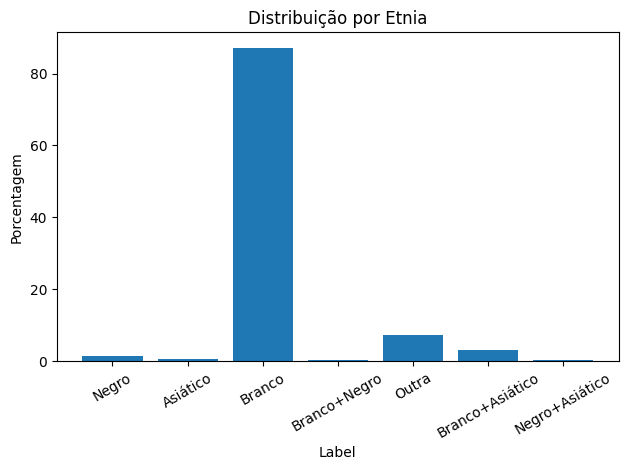

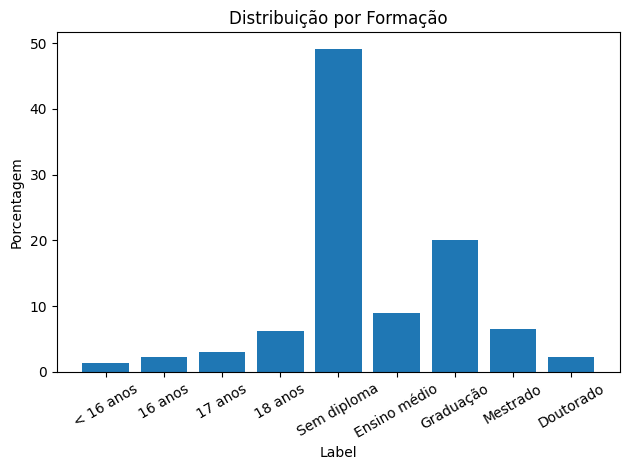

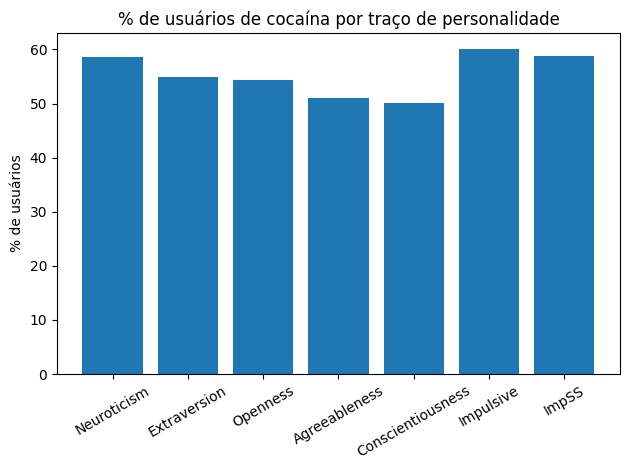

In [63]:
mask_users = df_usa["Coke"].isin(["CL2","CL3","CL4","CL5","CL6"])
y_coke = mask_users.astype(int)  # 1=usuário, 0=não-usuário

#Distribuição de usuários x não usuários
counts = y_coke.value_counts().sort_index()
perc = (counts / counts.sum() * 100).round(2)
coke_user_split = pd.DataFrame({
    "Valor": [0, 1],
    "Qtd": counts.reindex([0,1], fill_value=0).values,
    "%": perc.reindex([0,1], fill_value=0).values
})
coke_user_split["Label"] = coke_user_split["Valor"].map({0: "Não-usuário", 1: "Usuário"})

#print("Usuário (1) x Não-usuário (0)")
#display(coke_user_split)
#print("\n")


#Distribuição por nível CL0..CL6 para Cocaína
level_counts = df_usa["Coke"].value_counts().reindex(order, fill_value=0)
coke_df = pd.DataFrame({
    "Valor": order,
    "Qtd": level_counts.values,
})
coke_df["%"] = (coke_df["Qtd"] / coke_df["Qtd"].sum() * 100).round(2)
cl_map = { "CL0": "Nunca", "CL1": "> Década", "CL2": "Última década", "CL3": "Último ano", "CL4": "Último mês", "CL5": "Última semana", "CL6": "Último dia"}
coke_df["Label"] = coke_df["Valor"].map(cl_map)

#print("Nível de usuário de cocaína")
#display(coke_df)
#print("\n")



#Distribuição por gênero
gender_df = (df_usa.loc[mask_users, "gender"].value_counts().sort_index()
                .rename_axis("Valor").reset_index(name="Qtd"))
gender_df["%"] = (gender_df["Qtd"] / gender_df["Qtd"].sum() * 100).round(2)
gender_map = {0.48246: "Masculino", -0.48246: "Feminino"}
gender_df["Label"] = gender_df["Valor"].map(gender_map).fillna(gender_df["Valor"].round(5).astype(str))

#print("Usuário x Gênero")
#display(gender_df)
#print("\n")


#Distribuição por etnia
ethnicity_df = (df_usa.loc[mask_users, "ethnicity"].value_counts().sort_index()
                .rename_axis("Valor").reset_index(name="Qtd"))
ethnicity_df["%"] = (ethnicity_df["Qtd"] / ethnicity_df["Qtd"].sum() * 100).round(2)

ethnicity_map = {-0.31685: "Branco", -1.10702: "Negro", -0.50212: "Asiático", 1.90725: "Negro+Asiático", 0.12600: "Branco+Asiático", -0.22166: "Branco+Negro", 0.11440: "Outra"}
ethnicity_df["Label"] = ethnicity_df["Valor"].map(ethnicity_map).fillna(ethnicity_df["Valor"].round(5).astype(str))

#print("Usuário x Etnia")
#display(ethnicity_df)
#print("\n")


#Distribuição por formação
education_df = (df_usa.loc[mask_users, "education"].value_counts().sort_index()
                .rename_axis("Valor").reset_index(name="Qtd"))
education_df["%"] = (education_df["Qtd"] / education_df["Qtd"].sum() * 100).round(2)

education_map = {-2.43591: "< 16 anos", -1.73790: "16 anos", -1.43719: "17 anos", -1.22751: "18 anos", -0.61113: "Sem diploma", -0.05921: "Ensino médio", 0.45468: "Graduação", 1.16365: "Mestrado", 1.98437: "Doutorado"}
education_df["Label"] = education_df["Valor"].map(education_map).fillna(education_df["Valor"].round(5).astype(str))

#print("Usuário x Formação")
#display(education_df)
#print("\n")


#Porcentagem de usuario por traço de personalidade
traits = ["Neuroticism", "Extraversion", "Openness", "Agreeableness", "Conscientiousness", "Impulsive", "ImpSS"]
rows = []
for t in traits:
    s = pd.to_numeric(df_usa[t], errors="coerce")
    thr = s.median()
    mask = s >= thr
    # evita divisão por zero
    if mask.sum() > 0:
        pct = (mask_users[mask].mean() * 100).round(2)
    else:
        pct = np.nan
    rows.append((t, pct))

trait_pct_df = pd.DataFrame(rows, columns=["Traço", "%"])

print("Usuário x Traço")
display(trait_pct_df)
print("\n")

def _to_html(df):
    return df.to_html(index=False)

row1 = f"""
<div style="display:flex; gap:16px; align-items:flex-start; margin-bottom:16px;">
  <div style="flex:1;">
    <h4>Coke — Usuário (1) vs Não-usuário (0)</h4>
    {_to_html(coke_user_split)}
  </div>
  <div style="flex:1;">
    <h4>Coke — Níveis CL0..CL6</h4>
    {_to_html(coke_df)}
  </div>
  <div style="flex:1;">
    <h4>Traço</h4>
    {_to_html(trait_pct_df)}
  </div>
</div>
"""

row2 = f"""
<div style="display:flex; gap:16px; align-items:flex-start;">
  <div style="flex:1;">
    <h4>Gender</h4>
    {_to_html(gender_df)}
  </div>
  <div style="flex:1;">
    <h4>Ethnicity</h4>
    {_to_html(ethnicity_df)}
  </div>
  <div style="flex:1;">
    <h4>Education</h4>
    {_to_html(education_df)}
  </div>
</div>
"""

display(HTML("<h3>Tabelas por categoria: USA + Cocaína</h3><br>"))
display(HTML(row1 + row2))



# Função genérica para plotar barras a partir de uma tabela
def plot_bar(df, x_col, y_col, title, xlabel="", ylabel="Quantidade", rotation=0):
    plt.figure()
    plt.bar(df[x_col].astype(str), df[y_col])
    plt.title(title)
    plt.xlabel(xlabel if xlabel else x_col)
    plt.ylabel(ylabel if ylabel else y_col)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

plot_bar(
    coke_user_split,
    x_col="Label", y_col="%",
    title="Usuário (1) x Não-usuário (0)",
    xlabel="", ylabel="Porcentagem"
)

#Cocaina
x_col_coke = "Valor" if "Valor" in coke_df.columns else ("level" if "level" in coke_df.columns else "Label")
plot_bar(
    coke_df,
    x_col=x_col_coke, y_col="%",
    title="Cocaína — Níveis CL0..CL6",
    xlabel="Nível", ylabel="Porcentagem", rotation=0
)


#Genero, Etnia e Formação
def auto_xcol(df):
    return "Label" if "Label" in df.columns else "Valor"

plot_bar(
    gender_df,
    x_col=auto_xcol(gender_df), y_col="%",
    title="Distribuição por Gênero",
    xlabel="", ylabel="Porcentagem", rotation=30
)

plot_bar(
    ethnicity_df,
    x_col=auto_xcol(ethnicity_df), y_col="%",
    title="Distribuição por Etnia",
    xlabel="", ylabel="Porcentagem", rotation=30
)

plot_bar(
    education_df,
    x_col=auto_xcol(education_df), y_col="%",
    title="Distribuição por Formação",
    xlabel="", ylabel="Porcentagem", rotation=30
)

#Traço
plt.figure()
plt.bar(trait_pct_df["Traço"], trait_pct_df["%"])
plt.title("% de usuários de cocaína por traço de personalidade")
plt.ylabel("% de usuários")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()






## 4. Definição do target, variáveis e divisão dos dados

Definido problema como Classificação e target como Cocaína. Desconsiderei as colunas das outras drogas e removi colunas constantes, que nesse caso é a de país por já estar filtrado por USA.
Transformei os dados em binário, considerando CL0+CL1 = Não-Usuário e CL2 até CL6 = Usuário.
Por fim, dividi a base de treino e a base de teste em 0.20, como sugerido.

In [64]:
PROBLEM_TYPE = "classificacao"

# Excluindo as colunas de target, ID, outras drogas e outros países, para evitar data leakage e overfitting
if PROBLEM_TYPE == "classificacao":
    target = "Coke"
    base_df = df_usa
    order = ["CL0","CL1","CL2","CL3","CL4","CL5","CL6"]

    # Features numéricas do dataset (sem outras drogas / id)
    base_features = ["age","gender","education","country","ethnicity",
                     "Neuroticism","Extraversion","Openness",
                     "Agreeableness","Conscientiousness","Impulsive","ImpSS"]

    # Remover colunas constantes (country)
    features = [c for c in base_features if base_df[c].nunique(dropna=False) > 1]

    # X e y BINÁRIOS (CL2+ = usuário)
    X = base_df[features].copy()
    y = base_df[target].isin(order[2:]).astype(int)

    # Split (estratificado em classificação)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    print("PROBLEM_TYPE:", PROBLEM_TYPE)
    print("Target:", target)
    print("Features usadas:", features)
    print("Treino:", X_train.shape, "| Teste:", X_test.shape)
    print("Balanceamento (train):", y_train.value_counts().to_dict())
else:
    raise ValueError("PROBLEM_TYPE inválido.")

PROBLEM_TYPE: classificacao
Target: Coke
Features usadas: ['age', 'gender', 'education', 'ethnicity', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness', 'Impulsive', 'ImpSS']
Treino: (445, 11) | Teste: (112, 11)
Balanceamento (train): {1: 242, 0: 203}


## 5. Tratamento de dados e **Pipeline** de pré-processamento

Para a criação do pipeline, dividi as colunas em numéricas e categóricas, utilizando imputação e escala/encoding em cada uma.
Feito isso, juntei ambas por transformação e defini o pipeline básico com Logistic Regression, pela sua simplicidade e robustez.

In [65]:
#Tratamento de colunas numericas e categoricas
num_cols = [c for c in X_train.columns if str(X_train[c].dtype).startswith(("float","int"))]
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), #imputação
    ("scaler", StandardScaler()) #escala
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), #imputação
    ("onehot", OneHotEncoder(handle_unknown="ignore")) #encoding
])

#Combinando os pipelines
preprocess = ColumnTransformer(transformers=[ #transformação
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

#Definindo pipeline básico, com Logistic Regression para simplificar com robustez
pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("sel", SelectFromModel(
        LogisticRegression(class_weight="balanced", penalty="l1", solver="liblinear", max_iter=5000)
    )),
    ("clf", LogisticRegression(class_weight="balanced", penalty="l1", solver="liblinear", max_iter=5000))
])

print("num_cols:", num_cols[:12], "...")
print("cat_cols:", cat_cols[:5], "...")

num_cols: ['age', 'gender', 'education', 'ethnicity', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness', 'Impulsive', 'ImpSS'] ...
cat_cols: [] ...


## 6. Baseline e modelos candidatos

Para o baseline, utilizei o Dummy Classifier, como sugerido. Nos candidatos de treino, utilizei todas as abordagens vistas em aula, com balanceamento de classe nos modelos que aceitam. Posteriormente, filtrarei as melhores nas duas etapas de tunning.

In [66]:
# === Baselines ===
if PROBLEM_TYPE == "classificacao":
    baseline = Pipeline(steps=[("pre", preprocess),
                               ("model", DummyClassifier(strategy="most_frequent", random_state=SEED))])
    candidates = {
        "LogisticRegression": Pipeline([("pre", preprocess), ("model", LogisticRegression(max_iter=200, random_state=SEED, class_weight="balanced"))]),
        "RandomForest": Pipeline([("pre", preprocess), ("model", RandomForestClassifier(random_state=SEED, class_weight="balanced"))]),
        "KNN": Pipeline([("pre", preprocess), ("model", KNeighborsClassifier(n_neighbors=11))]),
        "GaussianNB": Pipeline([("pre", preprocess), ("model", GaussianNB())]),
        "DecisionTree": Pipeline([("pre", preprocess), ("model", DecisionTreeClassifier(random_state=SEED, class_weight="balanced"))]),
        "SVC-RBF": Pipeline([("pre", preprocess), ("model", SVC(kernel="rbf", probability=False, class_weight="balanced", random_state=SEED))]),
        #Bagging
        "Bagging(Tree)": Pipeline([("pre", preprocess), ("model", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=SEED),n_estimators=200, random_state=SEED, n_jobs=-1))]),
        #Boosting
        "GradientBoosting": Pipeline([("pre", preprocess), ("model", GradientBoostingClassifier(random_state=SEED))]),
        "AdaBoost": Pipeline([("pre", preprocess), ("model", AdaBoostClassifier(n_estimators=400, random_state=SEED))]),
        "ExtraTrees": Pipeline([("pre", preprocess), ("model", ExtraTreesClassifier(n_estimators=400, class_weight="balanced", random_state=SEED, n_jobs=-1))]),
        #voting
        "Voting(soft)": Pipeline([("pre", preprocess),
        ("model", VotingClassifier(
            estimators=[
                ("lr", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=SEED)),
                ("rf", RandomForestClassifier(n_estimators=400, class_weight="balanced_subsample",
                                             random_state=SEED, n_jobs=-1)),
                ("hgb", HistGradientBoostingClassifier(random_state=SEED)),
            ],
            voting="soft",
            weights=[2,1,2],
            n_jobs=-1
        ))])
    }
else:
    raise ValueError("PROBLEM_TYPE inválido.")

baseline

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'gender', 'education',
                                                   'ethnicity', 'Neuroticism',
                                                   'Extraversion', 'Openness',
                                                   'Agreeableness',
                                                   'Conscientiousness',
                                                   'Impulsive', 'ImpSS']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('model',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])

### 6.1 Treino e avaliação rápida (baseline vs candidatos)

Primeira etapa de treino básico comparando baseline e os outros candidatos.
Fica claro o overfitting nos modelos de árvore, alcançando 1.0 em todas as métricas. Já nos modelos de escala, tivemos resultados medianos, mais condizentes com a realidade.
Já o baseline variou bastante, com 1.0 em recall (overfitting) e 0.38 em F1 (underfitting).

Segue print da tabela de resultados.
Vamos ver como ficará após os ajustes.

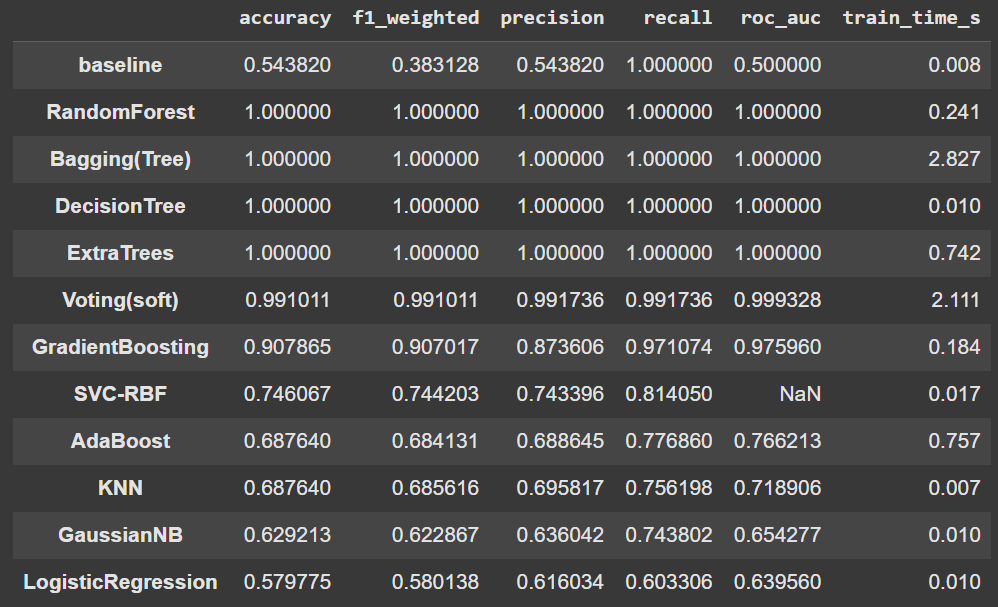

In [67]:
results = {}

if PROBLEM_TYPE in ["classificacao", "regressao"]:
    # Baseline
    t0 = time.time()
    baseline.fit(X_train, y_train)
    t1 = time.time()
    if PROBLEM_TYPE == "classificacao":
        y_pred = baseline.predict(X_train)
        proba = baseline.predict_proba(X_train) if hasattr(baseline, "predict_proba") else None
        results["baseline"] = evaluate_classification(y_train, y_pred, proba)
    else:
        y_pred = baseline.predict(X_train)
        results["baseline"] = evaluate_regression(y_train, y_pred)
    results["baseline"]["train_time_s"] = round(t1 - t0, 3)

    # Candidatos
    for name, pipe in candidates.items():
        t0 = time.time()
        pipe.fit(X_train, y_train)
        t1 = time.time()
        if PROBLEM_TYPE == "classificacao":
            y_pred = pipe.predict(X_train)
            proba = pipe.predict_proba(X_train) if hasattr(pipe, "predict_proba") else None
            results[name] = evaluate_classification(y_train, y_pred, proba)
        else:
            y_pred = pipe.predict(X_train)
            results[name] = evaluate_regression(y_train, y_pred)
        results[name]["train_time_s"] = round(t1 - t0, 3)

else:
    raise ValueError("PROBLEM_TYPE inválido.")


pd.DataFrame(results).T.sort_values("recall", ascending=False)

,accuracy,f1_weighted,precision,recall,roc_auc,train_time_s
baseline,0.543820,0.383128,0.543820,1.000000,0.500000,0.009
RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,0.254
Bagging(Tree),1.000000,1.000000,1.000000,1.000000,1.000000,3.192
DecisionTree,1.000000,1.000000,1.000000,1.000000,1.000000,0.010
ExtraTrees,1.000000,1.000000,1.000000,1.000000,1.000000,0.775
Voting(soft),0.991011,0.991011,0.991736,0.991736,0.999328,1.641
GradientBoosting,0.907865,0.907017,0.873606,0.971074,0.975960,0.299
SVC-RBF,0.746067,0.744203,0.743396,0.814050,NaN,0.018
AdaBoost,0.687640,0.684131,0.688645,0.776860,0.766213,2.176
KNN,0.687640,0.685616,0.695817,0.756198,0.718906,0.007



## 7. Validação e Otimização de Hiperparâmetros

Utilizarei StratifiedKFold para validação cruzada, considerando os 5 principais scorings e REFIT com Recall. Testei REFIT com cada um dos scorings, mas não tive mudanças significativas. O maior valor final foi para KNN com Recall.

Por isso e por entender que o Recall seja o mais apropriado para o tipo de problema apresentado, onde é importante minimizar os FN, seguirei dessa forma.

In [68]:
if PROBLEM_TYPE == "classificacao":
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    N_INTER = 10
    scoring = {
        "accuracy": "accuracy",
        "f1_weighted": "f1_weighted",
        "roc_auc": "roc_auc",
        "precision": "precision",
        "recall": "recall"
    }
    REFIT = "recall"
    param_spaces = {
        "LogisticRegression": {
            "model__C": loguniform(1e-2, 1e2),
            "model__penalty": ["l2"],
            "model__class_weight": [None, "balanced"],
            "model__solver": ["lbfgs"],
            "model__max_iter": randint(500, 2000),
        },
        "RandomForest": {
            "model__n_estimators": randint(150, 400),
            "model__max_depth": randint(3, 16),
            "model__min_samples_leaf": randint(1, 6),
            "model__min_samples_split": randint(2, 12),
            "model__max_features": uniform(0.3, 0.7),
            "model__class_weight": [None, "balanced_subsample"],
        },
        "ExtraTrees": {
            "model__n_estimators": randint(150, 400),
            "model__max_depth": randint(3, 16),
            "model__min_samples_leaf": randint(1, 6),
            "model__min_samples_split": randint(2, 12),
            "model__max_features": uniform(0.3, 0.7),
            "model__class_weight": [None, "balanced"],
        },
        "SVC-RBF": {
            "model__C": loguniform(1e-2, 1e2),
            "model__gamma": loguniform(1e-4, 1e0),
            "model__class_weight": [None, "balanced"],
        },
        "KNN": {
            "model__n_neighbors": randint(3, 51),
            "model__weights": ["uniform", "distance"],
            "model__p": [1, 2],  #Manhattan x Euclidiana
        },
        "DecisionTree": {
            "model__max_depth": randint(2, 30),
            "model__min_samples_leaf": randint(1, 10),
            "model__min_samples_split": randint(2, 20),
            "model__class_weight": [None, "balanced"],
        },
        "GradientBoosting": {
            "model__n_estimators": randint(100, 600),
            "model__learning_rate": loguniform(1e-2, 3e-1),
            "model__max_depth": randint(2, 6),
            "model__subsample": uniform(0.6, 0.4),
        },
        "AdaBoost": {
            "model__n_estimators": randint(100, 800),
            "model__learning_rate": loguniform(1e-2, 1),
        },
        "Bagging(Tree)": {
            "model__n_estimators": randint(100, 400),
            "model__estimator__max_depth": randint(2, 20),
            "model__estimator__min_samples_leaf": randint(1, 10),
        },
        "GaussianNB": {
            "model__var_smoothing": loguniform(1e-12, 1e-6),
        },
        "Voting(soft)": {
            "model__weights": [(1,1,1), (2,1,2), (3,1,2), (2,2,1)],
            #outros parametros foram removidos para deixar mais leve, por isso o warning avisando que só fará 4 iterações ao invés de 10 (n_inter):
        }
    }
else:
    raise ValueError("PROBLEM_TYPE inválido.")



# 7.1 Tunning - Fase 1

Na primeira etapa de tunning, utilizei Random Search por ter melhor custo/benefício em meio a tantos candidatos com tantos parâmetros. É mais rápido e consegue focar nos hiperparâmetros que mais importam para a análise.

Ao final, temos os 5 melhores modelos com seus valores em cada um dos scores, além de uma listagem com os melhores parâmetros para a segunda etapa de tunning.

O Recall do SVC ficou em 1.0 tanto para CV quanto para treino. É muito suspeito e pode ter vazamento ou overfitting, mas os outros scores ficaram "normais" e temos outros dois bons modelos para seguir, então vou deixar o SVC dessa forma para ver como ficará no final.

Abaixo, tabela resultante do Top 5:
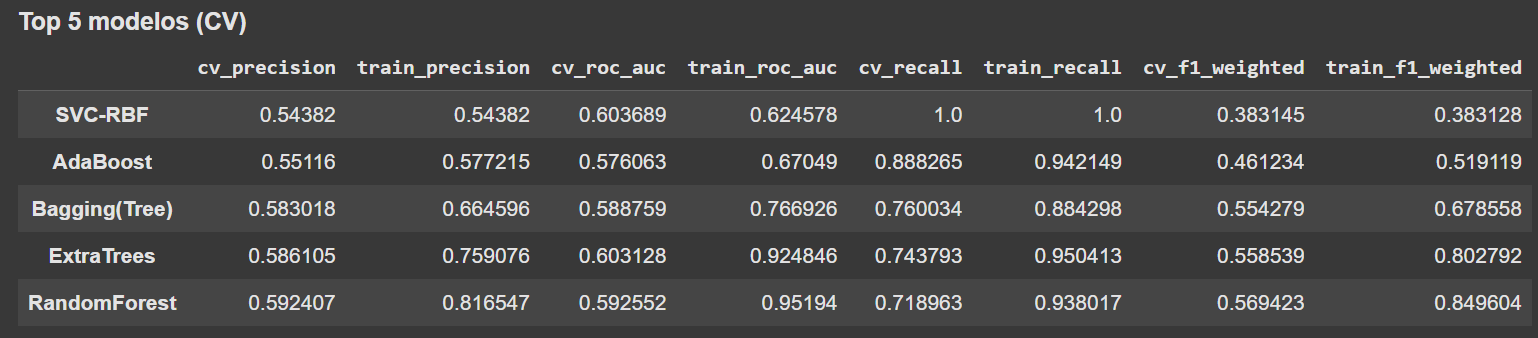

In [69]:
###### TUNNING FASE 1 ##########

tuned_results = {}
for name, pipe in candidates.items():
    space = param_spaces.get(name)
    if not space:
        print(f"[skip] sem espaço de busca para {name}")
        continue
    print(f"\n[TUNING] {name}")
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=space,
        n_iter=N_INTER,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        random_state=SEED,
        verbose=1,
        refit=REFIT
    )
    search.fit(X_train, y_train)
    print("Melhor score (CV):", search.best_score_)
    print("Melhores parâmetros:", search.best_params_)

    #Coleta de médias para utilizar futuramente
    best_idx = search.best_index_
    cv_mean_acc  = float(search.cv_results_[f"mean_test_{scoring['accuracy']}"][best_idx])
    cv_mean_f1w  = float(search.cv_results_[f"mean_test_{scoring['f1_weighted']}"][best_idx])
    cv_mean_prec  = float(search.cv_results_[f"mean_test_{scoring['precision']}"][best_idx])
    cv_mean_rec  = float(search.cv_results_[f"mean_test_{scoring['recall']}"][best_idx])
    cv_mean_auc  = float(search.cv_results_[f"mean_test_{scoring['roc_auc']}"][best_idx])
    cv_std_auc  = float(search.cv_results_["std_test_roc_auc"][best_idx])
    cv_fit_time  = float(search.cv_results_["mean_fit_time"][best_idx])

    #Para evitar SCV com NaN, considera o scores
    best_est = search.best_estimator_
    y_pred = best_est.predict(X_train)
    if hasattr(best_est, "predict_proba"):
        proba_or_scores = best_est.predict_proba(X_train)
        scores_vec = proba_or_scores[:, 1]
        train_metrics = evaluate_classification(y_train, y_pred, proba=proba_or_scores, scores=scores_vec)
    elif hasattr(best_est, "decision_function"):
        scores_vec = best_est.decision_function(X_train)
        train_metrics = evaluate_classification(y_train, y_pred, scores=scores_vec)
    else:
        train_metrics = evaluate_classification(y_train, y_pred)



    tuned_results[name] = {
        "cv_accuracy": cv_mean_acc,
        "cv_f1_weighted": cv_mean_f1w,
        "cv_precision": cv_mean_prec,
        "cv_recall": cv_mean_rec,
        "cv_roc_auc": cv_mean_auc,
        "cv_roc_auc_std": cv_std_auc,
        "cv_mean_fit_time_s": round(cv_fit_time, 3),
        "train_accuracy": train_metrics["accuracy"],
        "train_f1_weighted": train_metrics["f1_weighted"],
        "train_precision": train_metrics["precision"],
        "train_recall": train_metrics["recall"],
        "train_roc_auc": train_metrics["roc_auc"],
        "best_params": search.best_params_,
        "best_estimator": best_est,
    }


#Tabelas
res_df = (pd.DataFrame(tuned_results)
          .T.drop(columns=["best_estimator"])
          .sort_values("cv_recall", ascending=False))
display(res_df)


res_df = (pd.DataFrame(tuned_results)
          .T.drop(columns=["best_estimator"], errors="ignore"))
top5_models = res_df.sort_values(["cv_precision","train_precision","cv_roc_auc","train_roc_auc","cv_recall","train_recall","cv_f1_weighted","train_f1_weighted"], ascending=[True, True, True, True, False, True, True, True]).head(5)
print("\n\n\n\n")
display(HTML("<h3>Top 5 modelos - Tunning Fase 1 - Random Search</h3>"))
display(top5_models[["cv_precision","train_precision","cv_roc_auc","train_roc_auc","cv_recall","train_recall","cv_f1_weighted","train_f1_weighted"]])


[TUNING] LogisticRegression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor score (CV): 0.7399659863945579
Melhores parâmetros: {'model__C': np.float64(0.04207988669606638), 'model__class_weight': None, 'model__max_iter': 1738, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

[TUNING] RandomForest
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor score (CV): 0.7189625850340137
Melhores parâmetros: {'model__class_weight': None, 'model__max_depth': 6, 'model__max_features': np.float64(0.9655000144869412), 'model__min_samples_leaf': 3, 'model__min_samples_split': 9, 'model__n_estimators': 338}

[TUNING] KNN
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor score (CV): 0.8138605442176872
Melhores parâmetros: {'model__n_neighbors': 38, 'model__p': 2, 'model__weights': 'distance'}

[TUNING] GaussianNB
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor score (CV): 0.6856292517006803
Melhores parâmetros: {'model__var_s

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Melhor score (CV): 0.6737244897959184
Melhores parâmetros: {'model__weights': (2, 2, 1)}


,cv_accuracy,cv_f1_weighted,cv_precision,cv_recall,cv_roc_auc,cv_roc_auc_std,cv_mean_fit_time_s,train_accuracy,train_f1_weighted,train_precision,train_recall,train_roc_auc,best_params
SVC-RBF,0.54382,0.383145,0.54382,1.0,0.603689,0.027054,0.038,0.54382,0.383128,0.54382,1.0,0.624578,"{'model__C': 0.31489116479568624, 'model__clas..."
AdaBoost,0.546067,0.461234,0.55116,0.888265,0.576063,0.040082,1.069,0.593258,0.519119,0.577215,0.942149,0.67049,"{'model__learning_rate': 0.01930783753654714, ..."
KNN,0.622472,0.601315,0.616852,0.813861,0.617713,0.03866,0.014,1.0,1.0,1.0,1.0,1.0,"{'model__n_neighbors': 38, 'model__p': 2, 'mod..."
Bagging(Tree),0.575281,0.554279,0.583018,0.760034,0.588759,0.052709,2.066,0.694382,0.678558,0.664596,0.884298,0.766926,"{'model__estimator__max_depth': 3, 'model__est..."
ExtraTrees,0.575281,0.558539,0.586105,0.743793,0.603128,0.037987,0.455,0.808989,0.802792,0.759076,0.950413,0.924846,"{'model__class_weight': None, 'model__max_dept..."
LogisticRegression,0.591011,0.577707,0.600013,0.739966,0.607152,0.025849,0.016,0.624719,0.613203,0.624585,0.77686,0.639743,"{'model__C': 0.04207988669606638, 'model__clas..."
RandomForest,0.579775,0.569423,0.592407,0.718963,0.592552,0.049274,1.165,0.851685,0.849604,0.816547,0.938017,0.95194,"{'model__class_weight': None, 'model__max_dept..."
GaussianNB,0.588764,0.577369,0.609103,0.685629,0.610617,0.026246,0.015,0.629213,0.622867,0.636042,0.743802,0.654277,{'model__var_smoothing': 1.7670169402947963e-10}
Voting(soft),0.597753,0.594712,0.618902,0.673724,0.607335,0.040744,1.898,0.995506,0.995504,0.991803,1.0,0.999858,"{'model__weights': (2, 2, 1)}"
GradientBoosting,0.577528,0.573228,0.600268,0.665221,0.601551,0.049099,1.341,0.98427,0.984244,0.971888,1.0,0.999756,"{'model__learning_rate': 0.01607123851203988, ..."


,cv_precision,train_precision,cv_roc_auc,train_roc_auc,cv_recall,train_recall,cv_f1_weighted,train_f1_weighted
SVC-RBF,0.54382,0.54382,0.603689,0.624578,1.0,1.0,0.383145,0.383128
AdaBoost,0.55116,0.577215,0.576063,0.67049,0.888265,0.942149,0.461234,0.519119
Bagging(Tree),0.583018,0.664596,0.588759,0.766926,0.760034,0.884298,0.554279,0.678558
ExtraTrees,0.586105,0.759076,0.603128,0.924846,0.743793,0.950413,0.558539,0.802792
RandomForest,0.592407,0.816547,0.592552,0.95194,0.718963,0.938017,0.569423,0.849604


# 7.1 Tunning - Fase 2

Considerando o Top 5 da fase 1, e seus melhores parâmetros, selecionei 3 para seguirem na fase 2.
- SVC, pelo valor ideal de Recall, mesmo que me causando desconfiança. Ainda assim, o ROC está ok e os valores de treino não diferem muito dos valores de CV;
- Adaboost, por ótimo valor de Recall e por não ter muita diferença entre CV e treino, ainda que os outros scores possam melhorar na fase 2;
- Bagging, por ter um bons valores no geral e por ser um modelo em árvore, trazendo um olhar diferente em relação aos outros dois


Dessa vez, usei o Grid Search por ter menos modelos e regiões mais estreitas para uma análise mais profunda.


In [70]:
###### TUNNING FASE 2 ##########

if PROBLEM_TYPE == "classificacao":
  cv2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
  scoring2 = {
        "f1_weighted": "f1_weighted",
        "roc_auc": "roc_auc",
        "precision": "precision",
        "recall": "recall"
        }
  REFIT2 = "recall"

  param_grids = {
      "SVC-RBF": {
          "model__C": [0.25, 0.315, 0.5],
          "model__gamma": [2e-4, 5.4e-4, 1.2e-3],
          "model__class_weight": [None, "balanced"],
      },
      "AdaBoost": {
          "model__n_estimators": [180, 230, 280],
          "model__learning_rate": [0.01, 0.02, 0.05],
      },
      "Bagging(Tree)": {
          "model__n_estimators": [280, 360, 440],
          "model__max_samples": [0.6, 0.8],
          "model__estimator__max_depth": [2, 3],
          "model__estimator__min_samples_leaf": [6, 10],
          "model__estimator__class_weight": ["balanced"],
      },
  }
else:
    raise ValueError("PROBLEM_TYPE inválido.")


#Tunning com GridSearch para os 3 modelos, considerando os scores e Recall como REFIT
grid_results = {}
for name in ["SVC-RBF", "AdaBoost", "Bagging(Tree)"]:
    est = candidates[name]
    grid = param_grids[name]
    print(f"\n[GRID] {name} — combinações: {len(ParameterGrid(grid))}")

    gs = GridSearchCV(
        estimator=est,
        param_grid=grid,
        cv=cv2,
        scoring=scoring2,
        refit=REFIT2,
        n_jobs=-1,
        verbose=1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    best_idx = gs.best_index_
    best_est = gs.best_estimator_


    #Média de resultados no CV
    cv_prec   = float(gs.cv_results_["mean_test_precision"][best_idx])
    cv_rec    = float(gs.cv_results_["mean_test_recall"][best_idx])
    cv_f1w    = float(gs.cv_results_["mean_test_f1_weighted"][best_idx])
    cv_auc    = float(gs.cv_results_["mean_test_roc_auc"][best_idx])
    cv_time   = float(gs.cv_results_["mean_fit_time"][best_idx])

    #Resultados no Treino
    #best_est.fit(X_train, y_train)
    y_tr_pred = best_est.predict(X_train)
    if hasattr(best_est, "predict_proba"):
        tr_scores = best_est.predict_proba(X_train)[:, 1]
        train_metrics = evaluate_classification(y_train, y_tr_pred, proba=best_est.predict_proba(X_train))
    elif hasattr(best_est, "decision_function"):
        from sklearn.preprocessing import MinMaxScaler
        s = best_est.decision_function(X_train).reshape(-1,1)
        tr_scores = MinMaxScaler().fit_transform(s).ravel()
        train_metrics = evaluate_classification(y_train, y_tr_pred, scores=tr_scores)
    else:
        train_metrics = evaluate_classification(y_train, y_tr_pred)

    grid_results[name] = {
        "cv_precision":   cv_prec,
        "cv_recall":      cv_rec,
        "cv_f1_weighted": cv_f1w,
        "cv_roc_auc":     cv_auc,
        "cv_mean_fit_s":  round(cv_time, 3),
        "train_precision":   train_metrics["precision"],
        "train_recall":      train_metrics["recall"],
        "train_f1_weighted": train_metrics["f1_weighted"],
        "train_roc_auc":     train_metrics["roc_auc"],
        "best_params": gs.best_params_,
        "best_estimator": best_est,
    }

#Tabela
res_grid_full = (pd.DataFrame(grid_results)
                 .T.drop(columns=["cv_mean_fit_s","best_estimator", "best_params"], errors="ignore"))
res_grid = res_grid_full.sort_values(["cv_precision","train_precision","cv_roc_auc","train_roc_auc","cv_recall","train_recall","cv_f1_weighted","train_f1_weighted"], ascending=[True, True, True, True, False, True, True, True]).head(3)

display(HTML("<h3>Tunning Fase 2 — Grid Search</h3>"))
display(res_grid)


[GRID] SVC-RBF — combinações: 18
Fitting 5 folds for each of 18 candidates, totalling 90 fits

[GRID] AdaBoost — combinações: 9
Fitting 5 folds for each of 9 candidates, totalling 45 fits

[GRID] Bagging(Tree) — combinações: 24
Fitting 5 folds for each of 24 candidates, totalling 120 fits


,cv_precision,cv_recall,cv_f1_weighted,cv_roc_auc,train_precision,train_recall,train_f1_weighted,train_roc_auc
SVC-RBF,0.54382,1.0,0.383145,0.60379,0.54382,1.0,0.383128,0.624252
AdaBoost,0.555034,0.925765,0.457566,0.546702,0.577215,0.942149,0.519119,0.657544
Bagging(Tree),0.623646,0.635459,0.591961,0.598007,0.669231,0.719008,0.65211,0.709319


# 7.3 - Verificação de vazamento

Como o Recall se manteve em 1.0, achei que pudesse ter vazamento acontecendo. Então pesquisei por algumas formas de checar e cheguei no modelo abaixo.

Primeiro, fiz um Sanity Check, que embaralha as informações de target (usuários de cocaína nos EUA) da base de treino e roda a validação cruzada, para verificar se o modelo consegue acertar sem a informação real. Se a média for aproximadamente igual a 0,5, não há indícios de vazamento.
Para confirmar, fiz o Sanity Check com repetições (50). A média se manteve em 0,509 e o desvio padrão em 0,034, então realmente não há indícios de vazamento.


Depois fiz um OOF AUC (Out Of Fold AUC) para verificar a generalização e confirmar se o modelo realmente aprendeu, também utilizando validação cruzada.
Se o  OOF AUC for bem maior do que o Sanity Check, significa que o modelo aprendeu. No meu caso, o resultado foi de 0,601, não muito acima do Sanity, o que significa um modelo fraco.


Como não houve vazamento, seguirei com o SVC como modelo final.

In [71]:
best_name = res_grid.index[0]
best_model = grid_results[best_name]["best_estimator"]
print(f"Melhor modelo final: {best_name}")

#Sanity Check sem repetição
from sklearn.model_selection import cross_val_score
y_perm = y_train.sample(frac=1, random_state=SEED).values
auc_perm = cross_val_score(best_model, X_train, y_perm, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
print("AUC Sanity Check simples:", auc_perm)

#Sanity Check com 50 repetições
def perm_auc(seed):
    y_perm = y_train.sample(frac=1, random_state=seed).values
    return cross_val_score(best_model, X_train, y_perm, cv=cv, scoring="roc_auc", n_jobs=-1).mean()

scores = np.array([perm_auc(s) for s in range(50)])
print("Média Sanity Check repetitivo:",scores.mean())
print("Desvio Padrão Sanity Check repetitivo",scores.std())

#OOF AUC
from sklearn.model_selection import cross_val_predict
if hasattr(best_model, "predict_proba"):
    oof = cross_val_predict(best_model, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:,1]
else:
    dec = cross_val_predict(best_model, X_train, y_train, cv=cv, method="decision_function", n_jobs=-1)
    oof = MinMaxScaler().fit_transform(dec.reshape(-1,1)).ravel()

print("OOF AUC:", roc_auc_score(y_train, oof))


Melhor modelo final: SVC-RBF
AUC Sanity Check simples: 0.5360349261655882
Média Sanity Check repetitivo: 0.5090191471710636
Desvio Padrão Sanity Check repetitivo 0.0336962938867119
OOF AUC: 0.6009037983959614



## 8. Avaliação final, análise de erros e limitações

Iniciei a avaliação final pelo melhor modelo eleito, SVC. Como ele se manteve com 1.0 de recall, mesmo sem ter vazamento, acredito que houve generalização e todos os casos foram considerados como Positivo, seja Verdadeiro Positivo ou Falso Positivo. Então não é um modelo útil muito menos eficaz.

Avaliei, também, com AdaBoost e Bagging, para comparação. Após cada código, comento os resultados, mas de forma resumida o melhor candidato, na minha opinião, é o Bagging. Me parece que foi o que melhor aprendeu e não precisaria de muitos ajustes para melhorar.

Utilizei Matriz de Confusão, Curva AUC ROC e Piores casos previstos para análise de erros.

Melhor modelo final: SVC-RBF

Relatório do Melhor Modelo - SVC
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.54      1.00      0.71        61

    accuracy                           0.54       112
   macro avg       0.27      0.50      0.35       112
weighted avg       0.30      0.54      0.38       112

ROC-AUC baseline: 0.500
ROC-AUC SVC-RBF: 0.538 




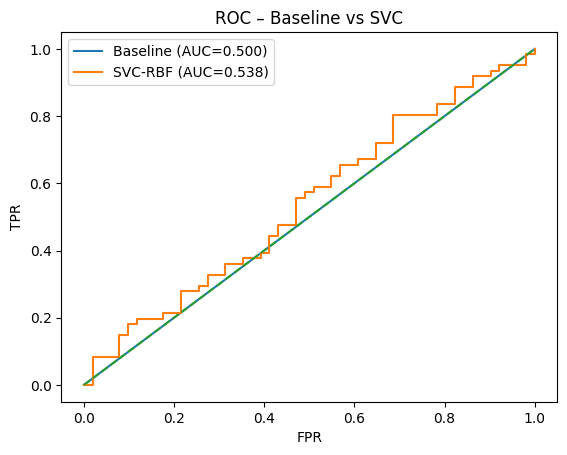

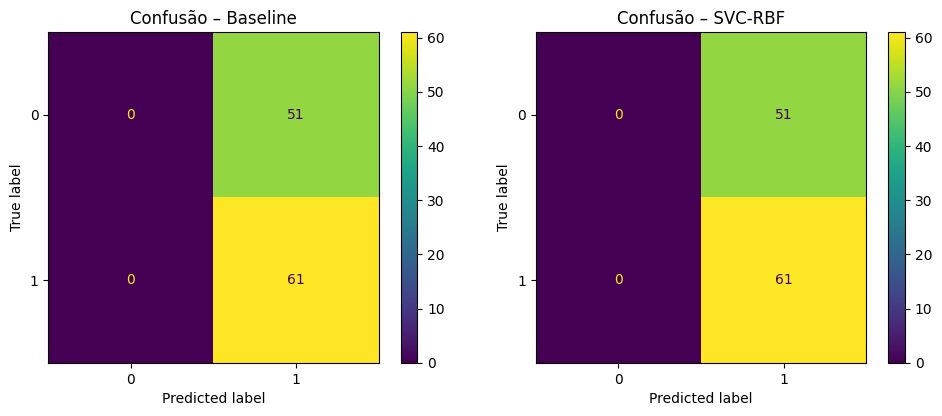


Piores FNs (10) — verdade = 1, modelo errou = 0


,y_true,y_pred_best,score_best,abs_resid



Piores FPs (10) — verdade = 0, modelo errou = 1


,y_true,y_pred_best,score_best,abs_resid
1751,0,1,1.000000,1.000000
1883,0,1,0.909101,0.909101
1021,0,1,0.904716,0.904716
1189,0,1,0.900411,0.900411
1524,0,1,0.868093,0.868093
1769,0,1,0.829133,0.829133
1759,0,1,0.824108,0.824108
1489,0,1,0.818805,0.818805
1183,0,1,0.809211,0.809211
1875,0,1,0.806192,0.806192


In [72]:
# 1) Escolher melhor modelo da Fase 2
best_name = res_grid.index[0]
best_model = grid_results[best_name]["best_estimator"]
print(f"Melhor modelo final: {best_name}")


# 2) Ajustar baseline e melhor no TREINO completo
baseline.fit(X_train, y_train)
best_model.fit(X_train, y_train)


# 3) Predições no TESTE
#Baseline
y_pred_base = baseline.predict(X_test)
proba_base = baseline.predict_proba(X_test)[:, 1] if hasattr(baseline, "predict_proba") else None
score_base = proba_base
if score_base is None and hasattr(baseline, "decision_function"):
    s = baseline.decision_function(X_test).reshape(-1,1)
    score_base = MinMaxScaler().fit_transform(s).ravel()

#Melhor modelo
y_pred_best = best_model.predict(X_test)
proba_best = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None
score_best = proba_best
if score_best is None and hasattr(best_model, "decision_function"):
    s = best_model.decision_function(X_test).reshape(-1,1)
    score_best = MinMaxScaler().fit_transform(s).ravel()


# 4) Métricas principais (Teste)
print("\nRelatório do Melhor Modelo - SVC")
print(classification_report(y_test, y_pred_best, zero_division=0))
auc_base = roc_auc_score(y_test, score_base) if score_base is not None else float('nan')
auc_best = roc_auc_score(y_test, score_best) if score_best is not None else float('nan')
print(f"ROC-AUC baseline: {auc_base:.3f}")
print(f"ROC-AUC {best_name}: {auc_best:.3f} \n\n")

# 5) ROC Curves (Baseline vs Melhor)
if (score_base is not None) and (score_best is not None):
    fpr_b, tpr_b, _ = roc_curve(y_test, score_base)
    fpr_m, tpr_m, _ = roc_curve(y_test, score_best)
    plt.figure()
    plt.plot(fpr_b, tpr_b, label=f"Baseline (AUC={auc_base:.3f})")
    plt.plot(fpr_m, tpr_m, label=f"{best_name} (AUC={auc_best:.3f})")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC – Baseline vs SVC")
    plt.legend(); plt.show()

# 6) Matrizes de confusão
fig, axes = plt.subplots(1, 2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base, ax=axes[0])
axes[0].set_title("Confusão – Baseline")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, ax=axes[1])
axes[1].set_title(f"Confusão – {best_name}")
plt.tight_layout(); plt.show()

# 7) Análise de erros
#   - “resíduo” de probabilidade: quanto o score difere da verdade (p/ classe 1, resid = |y - p1|)
#   - piores erros: FP muito confiantes (p alto mas y=0) e FN muito confiantes (p baixo mas y=1)
res_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred_best": y_pred_best,
    "score_best": score_best
}, index=X_test.index)
res_df["abs_resid"] = np.abs(res_df["y_true"] - res_df["score_best"])

# Tipos de erro
def err_type(row):
    if row["y_true"]==1 and row["y_pred_best"]==0: return "FN"
    if row["y_true"]==0 and row["y_pred_best"]==1: return "FP"
    if row["y_true"]==1 and row["y_pred_best"]==1: return "TP"
    return "TN"
res_df["err_type"] = res_df.apply(err_type, axis=1)

# Piores FN: y=1 mas score baixo (quanto menor score, pior; ou maior resid)
worst_fn = res_df[res_df["err_type"]=="FN"].sort_values(["score_best","abs_resid"], ascending=[True, False]).head(10)
# Piores FP: y=0 mas score alto (quanto maior score, pior)
worst_fp = res_df[res_df["err_type"]=="FP"].sort_values(["score_best","abs_resid"], ascending=[False, False]).head(10)

print("\nPiores FNs (10) — verdade = 1, modelo errou = 0")
display(worst_fn[["y_true","y_pred_best","score_best","abs_resid"]])

print("\nPiores FPs (10) — verdade = 0, modelo errou = 1")
display(worst_fp[["y_true","y_pred_best","score_best","abs_resid"]])


Como previsto, o modelo não aprendeu nada e marcou tudo como Positivo, daí temos a matriz de confusão dividia somente em Falsos Positivos e Verdadeiros Positivos. Dessa forma, o modelo não é útil.

Como o modelo trouxe um resultado igual ao baseline, penso em melhorias no início do código, como a adição de features para interações entre colunas envolvendo os traços de personalidade. Também incluir o pipeline completo dentro de um classificador calibrado (CalibratedClassifierCV), para o modelo lidar melhor com as probabilidades e desbalanceamentos.

Acredito, também, que uma base de dados maior poderia ajudar no treinamento, com mais informações de treino e teste.


A seguir, repetirei o teste considerando o AdaBoost, que ficou em segundo como melhor modelo. Na sequência, farei para Bagging, terceiro colocado.

Segundo melhor modelo final: AdaBoost

Relatório do Segundo Melhor Modelo - AdaBoost
              precision    recall  f1-score   support

           0       0.40      0.04      0.07        51
           1       0.54      0.95      0.69        61

    accuracy                           0.54       112
   macro avg       0.47      0.50      0.38       112
weighted avg       0.48      0.54      0.41       112

ROC-AUC baseline: 0.500
ROC-AUC AdaBoost: 0.572 




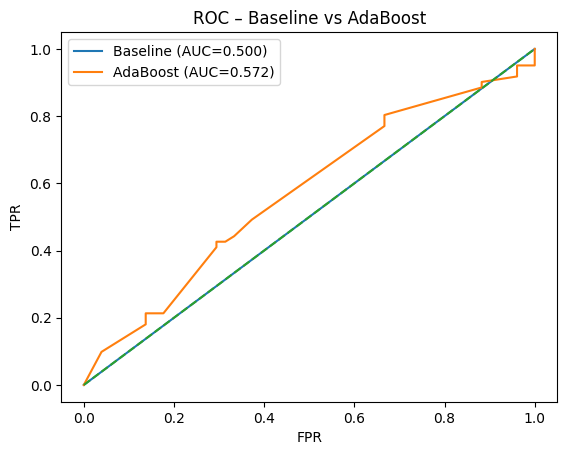

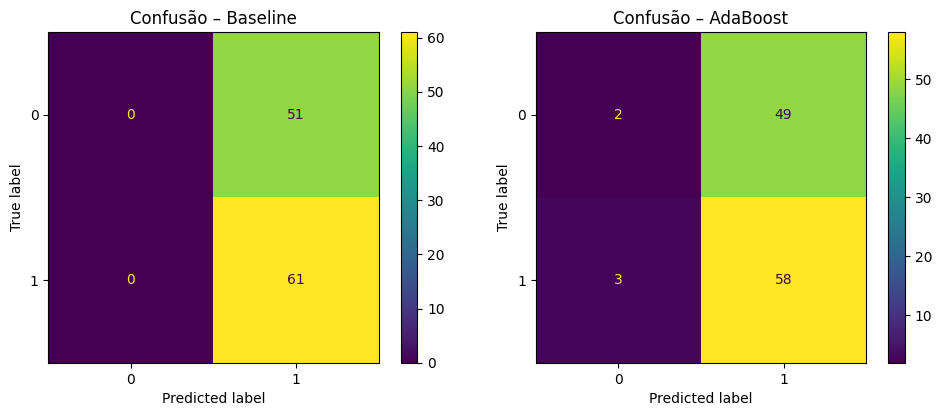


Piores FNs (10) — verdade = 1, modelo errou = 0


,y_true,sec_y_pred_best,sec_score_best,abs_resid
1514,1,0,0.187126,0.812874
1832,1,0,0.187126,0.812874
1490,1,0,0.225792,0.774208



Piores FPs (10) — verdade = 0, modelo errou = 1


,y_true,sec_y_pred_best,sec_score_best,abs_resid
1883,0,1,0.841969,0.841969
1751,0,1,0.841969,0.841969
514,0,1,0.832156,0.832156
600,0,1,0.810803,0.810803
1759,0,1,0.807894,0.807894
1524,0,1,0.807894,0.807894
1826,0,1,0.807894,0.807894
1748,0,1,0.790169,0.790169
1469,0,1,0.790169,0.790169
1075,0,1,0.781416,0.781416


In [73]:
# 1) Escolher segundo melhor modelo da Fase 2
sec_best_name = "AdaBoost"
sec_best_model = grid_results[sec_best_name]["best_estimator"]
print(f"Segundo melhor modelo final: {sec_best_name}")


# 2) Ajustar baseline e melhor no TREINO completo
baseline.fit(X_train, y_train)
sec_best_model.fit(X_train, y_train)


# 3) Predições no TESTE
#Baseline
sec_y_pred_base = baseline.predict(X_test)
sec_proba_base = baseline.predict_proba(X_test)[:, 1] if hasattr(baseline, "predict_proba") else None
sec_score_base = sec_proba_base
if sec_score_base is None and hasattr(baseline, "decision_function"):
    sec_s = baseline.decision_function(X_test).reshape(-1,1)
    sec_score_base = MinMaxScaler().fit_transform(sec_s).ravel()

#Melhor modelo
sec_y_pred_best = sec_best_model.predict(X_test)
sec_proba_best = sec_best_model.predict_proba(X_test)[:, 1] if hasattr(sec_best_model, "predict_proba") else None
sec_score_best = sec_proba_best
if sec_score_best is None and hasattr(sec_best_model, "decision_function"):
    sec_s = sec_best_model.decision_function(X_test).reshape(-1,1)
    sec_score_best = MinMaxScaler().fit_transform(sec_s).ravel()


# 4) Métricas principais (Teste)
print("\nRelatório do Segundo Melhor Modelo - AdaBoost")
print(classification_report(y_test, sec_y_pred_best, zero_division=0))
sec_auc_base = roc_auc_score(y_test, sec_score_base) if sec_score_base is not None else float('nan')
sec_auc_best = roc_auc_score(y_test, sec_score_best) if sec_score_best is not None else float('nan')
print(f"ROC-AUC baseline: {sec_auc_base:.3f}")
print(f"ROC-AUC {sec_best_name}: {sec_auc_best:.3f} \n\n")

# 5) ROC Curves (Baseline vs Melhor)
if (sec_score_base is not None) and (sec_score_best is not None):
    fpr_b, tpr_b, _ = roc_curve(y_test, sec_score_base)
    fpr_m, tpr_m, _ = roc_curve(y_test, sec_score_best)
    plt.figure()
    plt.plot(fpr_b, tpr_b, label=f"Baseline (AUC={sec_auc_base:.3f})")
    plt.plot(fpr_m, tpr_m, label=f"{sec_best_name} (AUC={sec_auc_best:.3f})")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC – Baseline vs AdaBoost")
    plt.legend(); plt.show()

# 6) Matrizes de confusão
fig, axes = plt.subplots(1, 2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_test, sec_y_pred_base, ax=axes[0])
axes[0].set_title("Confusão – Baseline")
ConfusionMatrixDisplay.from_predictions(y_test, sec_y_pred_best, ax=axes[1])
axes[1].set_title(f"Confusão – {sec_best_name}")
plt.tight_layout(); plt.show()

# 7) Análise de erros
#Piores erros: FP - muito confiantes e FN muito confiantes
res_df = pd.DataFrame({
    "y_true": y_test.values,
    "sec_y_pred_best": sec_y_pred_best,
    "sec_score_best": sec_score_best
}, index=X_test.index)
res_df["abs_resid"] = np.abs(res_df["y_true"] - res_df["sec_score_best"])

# Tipos de erro
def err_type(row):
    if row["y_true"]==1 and row["sec_y_pred_best"]==0: return "FN"
    if row["y_true"]==0 and row["sec_y_pred_best"]==1: return "FP"
    if row["y_true"]==1 and row["sec_y_pred_best"]==1: return "TP"
    return "TN"
res_df["err_type"] = res_df.apply(err_type, axis=1)

# Piores FN: y=1 mas score baixo (quanto menor score, pior; ou maior resid)
worst_fn = res_df[res_df["err_type"]=="FN"].sort_values(["sec_score_best","abs_resid"], ascending=[True, False]).head(10)
# Piores FP: y=0 mas score alto (quanto maior score, pior)
worst_fp = res_df[res_df["err_type"]=="FP"].sort_values(["sec_score_best","abs_resid"], ascending=[False, False]).head(10)

print("\nPiores FNs (10) — verdade = 1, modelo errou = 0")
display(worst_fn[["y_true","sec_y_pred_best","sec_score_best","abs_resid"]])

print("\nPiores FPs (10) — verdade = 0, modelo errou = 1")
display(worst_fp[["y_true","sec_y_pred_best","sec_score_best","abs_resid"]])


Com o AdaBoost, parece que o modelo aprende um pouquinho mais, agora com menos Falso Positivo (49 x 51 no SVC), mas ainda é um valor bem alto e acredito que ainda seja um modelo fraco. Entendo que os mesmos ajustes anteriores trariam benefícios para esse também. Além disso, podemos ajustar o threshold com o uso do F0,5-Score utilizando um Beta de 0,5 e dando mais peso para a Precisão.

A seguir, farei a avaliação com Bagging.

Terceiro melhor modelo final: Bagging(Tree)

Relatório do Terceiro Melhor Modelo - Bagging
              precision    recall  f1-score   support

           0       0.55      0.41      0.47        51
           1       0.59      0.72      0.65        61

    accuracy                           0.58       112
   macro avg       0.57      0.57      0.56       112
weighted avg       0.58      0.58      0.57       112

ROC-AUC baseline: 0.500
ROC-AUC Bagging(Tree): 0.594 




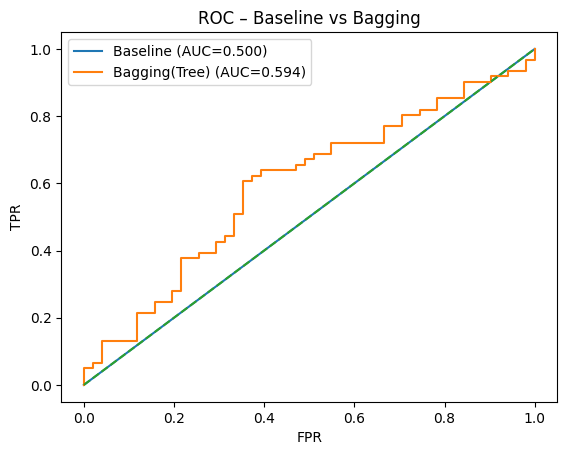

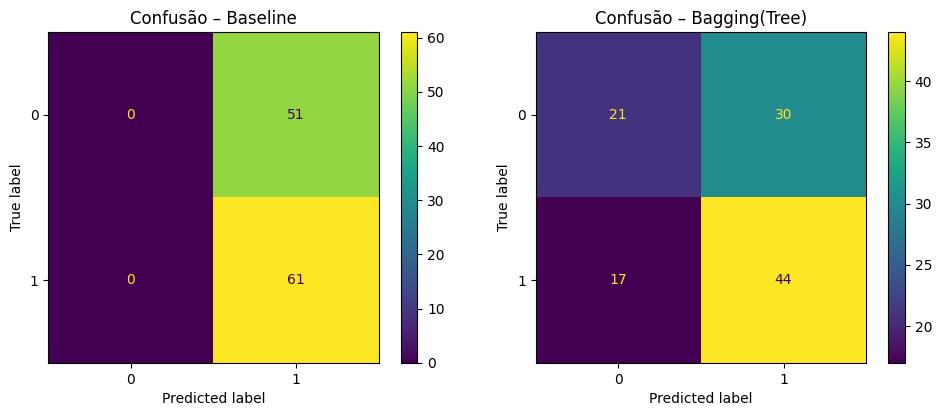


Piores FNs (10) — verdade = 1, modelo errou = 0


,y_true,tir_y_pred_best,tir_score_best,abs_resid
590,1,0,0.359411,0.640589
1320,1,0,0.374809,0.625191
1490,1,0,0.406014,0.593986
1311,1,0,0.413486,0.586514
1851,1,0,0.427522,0.572478
996,1,0,0.428557,0.571443
1053,1,0,0.438539,0.561461
1514,1,0,0.440633,0.559367
1832,1,0,0.444979,0.555021
765,1,0,0.459035,0.540965



Piores FPs (10) — verdade = 0, modelo errou = 1


,y_true,tir_y_pred_best,tir_score_best,abs_resid
1751,0,1,0.668725,0.668725
1883,0,1,0.663528,0.663528
1748,0,1,0.625385,0.625385
1524,0,1,0.624077,0.624077
1759,0,1,0.614092,0.614092
600,0,1,0.613504,0.613504
1189,0,1,0.586264,0.586264
896,0,1,0.583866,0.583866
1021,0,1,0.578991,0.578991
1826,0,1,0.576768,0.576768


In [74]:
# 1) Escolher terceiro melhor modelo da Fase 2
tir_best_name = "Bagging(Tree)"
tir_best_model = grid_results[tir_best_name]["best_estimator"]
print(f"Terceiro melhor modelo final: {tir_best_name}")


# 2) Ajustar baseline e melhor no TREINO completo
baseline.fit(X_train, y_train)
tir_best_model.fit(X_train, y_train)


# 3) Predições no TESTE
#Baseline
tir_y_pred_base = baseline.predict(X_test)
tir_proba_base = baseline.predict_proba(X_test)[:, 1] if hasattr(baseline, "predict_proba") else None
tir_score_base = tir_proba_base
if tir_score_base is None and hasattr(baseline, "decision_function"):
    tir_s = baseline.decision_function(X_test).reshape(-1,1)
    tir_score_base = MinMaxScaler().fit_transform(tir_s).ravel()

#Melhor modelo
tir_y_pred_best = tir_best_model.predict(X_test)
tir_proba_best = tir_best_model.predict_proba(X_test)[:, 1] if hasattr(tir_best_model, "predict_proba") else None
tir_score_best = tir_proba_best
if tir_score_best is None and hasattr(tir_best_model, "decision_function"):
    tir_s = tir_best_model.decision_function(X_test).reshape(-1,1)
    tir_score_best = MinMaxScaler().fit_transform(tir_s).ravel()


# 4) Métricas principais (Teste)
print("\nRelatório do Terceiro Melhor Modelo - Bagging")
print(classification_report(y_test, tir_y_pred_best, zero_division=0))
tir_auc_base = roc_auc_score(y_test, tir_score_base) if tir_score_base is not None else float('nan')
tir_auc_best = roc_auc_score(y_test, tir_score_best) if tir_score_best is not None else float('nan')
print(f"ROC-AUC baseline: {tir_auc_base:.3f}")
print(f"ROC-AUC {tir_best_name}: {tir_auc_best:.3f} \n\n")

# 5) ROC Curves (Baseline vs Melhor)
if (tir_score_base is not None) and (tir_score_best is not None):
    fpr_b, tpr_b, _ = roc_curve(y_test, tir_score_base)
    fpr_m, tpr_m, _ = roc_curve(y_test, tir_score_best)
    plt.figure()
    plt.plot(fpr_b, tpr_b, label=f"Baseline (AUC={tir_auc_base:.3f})")
    plt.plot(fpr_m, tpr_m, label=f"{tir_best_name} (AUC={tir_auc_best:.3f})")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC – Baseline vs Bagging")
    plt.legend(); plt.show()

# 6) Matrizes de confusão
fig, axes = plt.subplots(1, 2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_test, tir_y_pred_base, ax=axes[0])
axes[0].set_title("Confusão – Baseline")
ConfusionMatrixDisplay.from_predictions(y_test, tir_y_pred_best, ax=axes[1])
axes[1].set_title(f"Confusão – {tir_best_name}")
plt.tight_layout(); plt.show()

# 7) Análise de erros
#Piores erros: FP - muito confiantes e FN muito confiantes
res_df = pd.DataFrame({
    "y_true": y_test.values,
    "tir_y_pred_best": tir_y_pred_best,
    "tir_score_best": tir_score_best
}, index=X_test.index)
res_df["abs_resid"] = np.abs(res_df["y_true"] - res_df["tir_score_best"])

# Tipos de erro
def err_type(row):
    if row["y_true"]==1 and row["tir_y_pred_best"]==0: return "FN"
    if row["y_true"]==0 and row["tir_y_pred_best"]==1: return "FP"
    if row["y_true"]==1 and row["tir_y_pred_best"]==1: return "TP"
    return "TN"
res_df["err_type"] = res_df.apply(err_type, axis=1)

# Piores FN: y=1 mas score baixo (quanto menor score, pior; ou maior resid)
worst_fn = res_df[res_df["err_type"]=="FN"].sort_values(["tir_score_best","abs_resid"], ascending=[True, False]).head(10)
# Piores FP: y=0 mas score alto (quanto maior score, pior)
worst_fp = res_df[res_df["err_type"]=="FP"].sort_values(["tir_score_best","abs_resid"], ascending=[False, False]).head(10)

print("\nPiores FNs (10) — verdade = 1, modelo errou = 0")
display(worst_fn[["y_true","tir_y_pred_best","tir_score_best","abs_resid"]])

print("\nPiores FPs (10) — verdade = 0, modelo errou = 1")
display(worst_fp[["y_true","tir_y_pred_best","tir_score_best","abs_resid"]])


Por fim, na minha percepção, o Bagging (terceiro melhor modelo) foi o que mais aprendeu. Teve resultado ok em Recall e levemente melhor em Precisão, Acurácia e F1. Reduziu os FPs, aumentou os VN e os FN foram a minoria.
Com ajustes de threshold, calibração e mais dados, acredito que esse possa ser o modelo mais eficaz na predição de usuários de cocaína, podendo expandir para outros países e outras drogas.

# 9 - Conclusão

Independente de modelos, acredito que uma maior base de dados e talvez com menos variáveis trariam melhores resultados por ter mais material de treino e teste.

Por falta de, minimamente, ajuste fino e calibração, o modelo vencedor da análise - SVC - não aprendeu de verdade e acabou generalizando todos os dados como Positivo, talvez por influência de ter o Recall como principal score. Com isso, a quantidade de Falsos Positivos foi altíssima e inutilizou o modelo. Me parece que precisaria de mais complexidade e ajustes no modelo para que ele se tornasse eficaz.

Com o AdaBoost, houve uma melhora em relação ao SVC, mas ainda haviam muitos FPs e não vi um ganho muito grande nos outros parâmetros.

Já com Bagging, achei ter obtido o resultado mais equilibrado entre a principal necessidade (menor FN possível) e menor FP, mostrando que não generalizou e aprendeu mais. Me parece que aqui precisaríamos de menos ajustes para melhorar o modelo, se tornando mais fácil de seguir em frente.